<a href="https://colab.research.google.com/github/williamsdoug/CTG_RP/blob/master/CTG_RP_Train_ResNet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate Datasets and Train ResNet Model

In [1]:
! ls

basic_denoise.py     config_local.py  ctu-uhb-ctgdb  libRP.py	  sample_data
compute_metadata.py  ctg_utils.py     images	     __pycache__  test.py


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import config_local
from config_local import *

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.metrics import error_rate

import torch
from torch import nn


import collections
import pprint

In [0]:
from compute_metadata import get_splits, generate_label_file, generate_lists

## Config

In [0]:
tfms=[]
size=64*2
bs=64
workers=4

path = Path() / 'images'

## Generate Train and Valid Label Files

In [0]:
train_valid_groups_full = get_splits(image_dir='images', image_file='rp_images_index.json', 
                                     exclude=['_clipped'],
                                     thresh = 7.15)
              
# Create valid_x.csv files for each split
for i in range(len(train_valid_groups_full)):
    generate_lists(train_valid_groups_full[i], train_file='train_{}.csv'.format(i),
                   valid_file='valid_{}.csv'.format(i))

In [8]:
!ls images/*.csv

images/train_0.csv  images/train_3.csv	images/valid_1.csv  images/valid_4.csv
images/train_1.csv  images/train_4.csv	images/valid_2.csv
images/train_2.csv  images/valid_0.csv	images/valid_3.csv


In [0]:
train = ImageList.from_csv(path, 'train_0.csv')
valid = ImageList.from_csv(path, 'valid_0.csv')

lls = ItemLists(path, train, valid).label_from_df(cols=1).transform(tfms, size=size) 
db = lls.databunch(bs=bs, num_workers=workers)#.normalize(imagenet_stats)

### Examine Results

In [10]:
print('nClass: {}    classes: {}'.format(db.c, db.classes))
db

nClass: 2    classes: [0, 1]


ImageDataBunch;

Train: LabelList (492 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,0
Path: images;

Valid: LabelList (120 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,0
Path: images;

Test: None

492 torch.Size([599, 599])


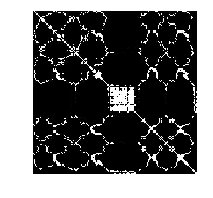

In [11]:
im = train.get(-1)
print(len(train), im.size)
im.show()

## Model

In [0]:
learn = cnn_learner(db, models.resnet34, metrics=accuracy)
learn.summary()
learn.save('initial')

# Train Model

In [13]:
learn.fit_one_cycle(1)  # learn.fit_one_cycle(1, 0.01)

learn.save('save-1')

epoch,train_loss,valid_loss,accuracy,time
0,0.947643,0.759221,0.458333,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


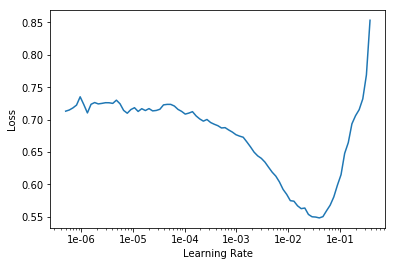

In [14]:
learn.lr_find(end_lr=1)
learn.recorder.plot()

In [15]:
learn.load('save-1')
learn.fit_one_cycle(4, 1e-3)  # learn.fit_one_cycle(1, 0.01)
learn.save('save-2')

epoch,train_loss,valid_loss,accuracy,time
0,0.676482,0.835752,0.433333,00:05
1,0.634319,0.934840,0.458333,00:05
2,0.601045,0.966254,0.433333,00:05
3,0.568352,0.973235,0.500000,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


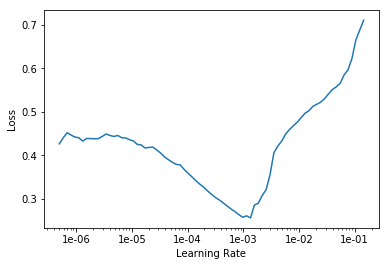

In [16]:
learn.load('save-2')
learn.unfreeze()
learn.lr_find(end_lr=1)
learn.recorder.plot()

In [17]:
learn.load('save-2')
learn.unfreeze()
learn.fit_one_cycle(4, 7e-5)  # learn.fit_one_cycle(1, 0.01)
learn.save('save-3')

epoch,train_loss,valid_loss,accuracy,time
0,0.454461,0.983606,0.525000,00:05
1,0.364157,1.082769,0.550000,00:05
2,0.277814,1.003265,0.558333,00:05
3,0.227201,1.001673,0.516667,00:05
